In [1]:
import psfr
from psfr.psfr import stack_psf, one_step_psf_estimate, _linear_amplitude, centroid_fit, shift_psf
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Util import util
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Testing
This is incomplete and needs to be improved during packaging

/var/folders/qy/xljgq5_15q577p5p_m75rp2h0000gn/T/ipykernel_42911/1380372288.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diff_after = np.sum((psf_after_super - psf_true_super)**2)


ValueError: operands could not be broadcast together with shapes (2,) (41,41) 

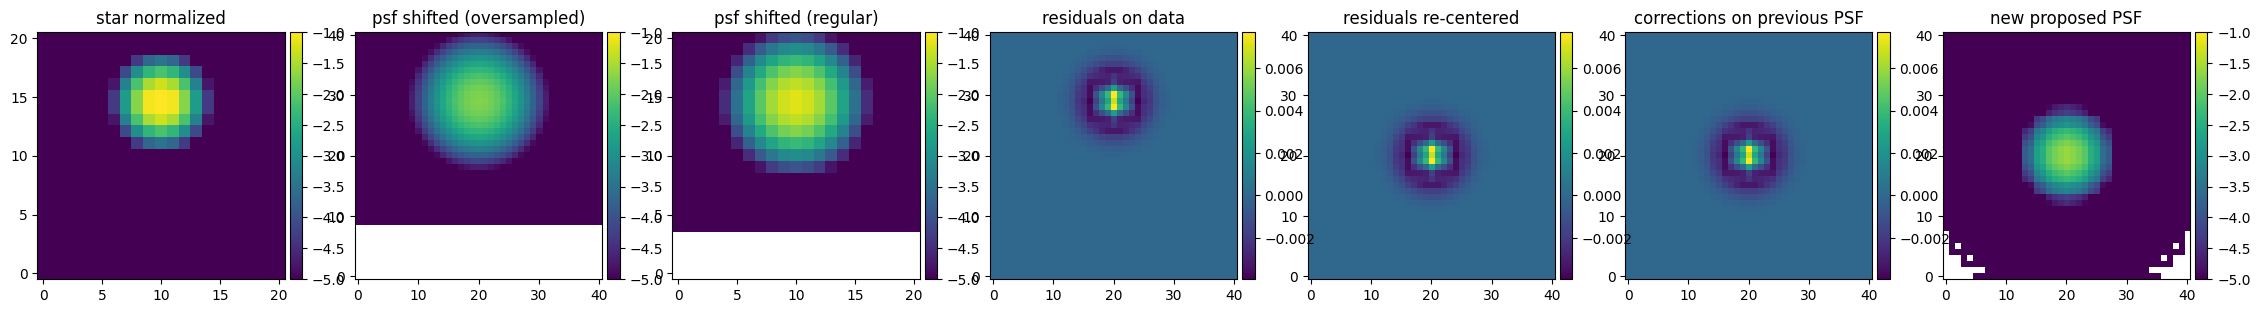

In [3]:
def test_one_step_psf_estimation():
    
    from lenstronomy.LightModel.light_model import LightModel
    numpix = 21
    n_c = (numpix - 1) / 2
    x_grid, y_grid = util.make_grid(numPix=21, deltapix=1, left_lower=False)
    gauss = LightModel(['GAUSSIAN'])
    sigma = 1
    kwargs_true = [{'amp': 1, 'sigma': sigma, 'center_x': 0, 'center_y': 0}]
    flux_true = gauss.surface_brightness(x_grid, y_grid, kwargs_true)
    psf_true = util.array2image(flux_true)
    psf_true /= np.sum(psf_true)
    
    kwargs_guess = [{'amp': 1, 'sigma': 1.5, 'center_x': 0, 'center_y': 0}]
    flux_guess = gauss.surface_brightness(x_grid, y_grid, kwargs_guess)
    psf_guess = util.array2image(flux_guess)
    psf_guess /= np.sum(psf_guess)
    
    center_list = []
    star_list = []
    displacement_scale = 1
    
    x_c, y_c = 0., 4.5
    center_list.append(np.array([x_c, y_c]))
    kwargs_model = [{'amp': 1, 'sigma': sigma, 'center_x': x_c, 'center_y': y_c}]
    flux_model = gauss.surface_brightness(x_grid, y_grid, kwargs_model)
    star = util.array2image(flux_model)
    star_list.append(star)
    
    
    
    oversampling = 2
    numpix_super = numpix * oversampling
    if oversampling % 2 == 0:
        numpix_super -= 1
    
    x_grid_super, y_grid_super = util.make_grid(numPix=numpix_super, deltapix=1. / oversampling, left_lower=False)
    flux_guess_super = gauss.surface_brightness(x_grid_super, y_grid_super, kwargs_guess)
    psf_guess_super = util.array2image(flux_guess_super)
    psf_guess_super /= np.sum(psf_guess_super)
    
    flux_true_super = gauss.surface_brightness(x_grid_super, y_grid_super, kwargs_true)
    psf_true_super = util.array2image(flux_true_super)
    psf_true_super /= np.sum(psf_true_super)

    psf_after_super = one_step_psf_estimate(star_list, psf_guess_super, center_list, mask_list=None, 
                                      error_map_list=None, step_factor=0.2, oversampling=oversampling, verbose=True)
    
    # psf_after = one_step_psf_estimate(star_list, psf_guess, center_list, mask_list=None, error_map_list=None, step_factor=0.2, verbose=True)
    # psf_after should be a better guess of psf_true than psf_guess
    diff_after = np.sum((psf_after_super - psf_true_super)**2)
    diff_before = np.sum((psf_guess_super - psf_true_super)**2)
    
    plt.imshow(psf_true_super - psf_after_super)
    plt.colorbar()
    plt.title('after')
    plt.show()
    plt.imshow(psf_true_super - psf_guess_super)
    plt.colorbar()
    plt.title('before')
    plt.show()
    
    plt.imshow(psf_after_super - psf_guess_super)
    plt.colorbar()
    plt.title('after - before')
    plt.show()
    
    assert diff_after < diff_before
    
    
    
test_one_step_psf_estimation()

In [4]:
import numpy.testing as npt

def test_linear_amplitude():
    amp = 2
    data = np.ones((5, 5)) * amp
    model = np.ones((5, 5))

    amp_return = _linear_amplitude(data, model)
    npt.assert_almost_equal(amp_return, amp)
    
    mask = np.ones_like(data)
    
    amp_return = _linear_amplitude(data, model, mask=mask)
    npt.assert_almost_equal(amp_return, amp)
    
test_linear_amplitude()


def test_fit_centroid():


    from lenstronomy.LightModel.light_model import LightModel
    numpix = 21
    n_c = (numpix - 1) / 2
    x_grid, y_grid = util.make_grid(numPix=21, deltapix=1, left_lower=True)
    gauss = LightModel(['GAUSSIAN'])
    x_c, y_c = -0.6, 0.2
    kwargs_true = [{'amp': 2, 'sigma': 1, 'center_x': n_c + x_c, 'center_y': n_c + y_c}]
    kwargs_model = [{'amp': 1, 'sigma': 1, 'center_x': n_c, 'center_y': n_c}]
    flux_true = gauss.surface_brightness(x_grid, y_grid, kwargs_true)
    flux_true = util.array2image(flux_true)

    flux_model = gauss.surface_brightness(x_grid, y_grid, kwargs_model)
    flux_model = util.array2image(flux_model)

    mask = np.ones_like(flux_true)

    center = centroid_fit(flux_true, flux_model, mask=mask, variance=None)
    npt.assert_almost_equal(center[0], x_c, decimal=1)
    npt.assert_almost_equal(center[1], y_c, decimal=1)
    
test_fit_centroid()


def test_one_step_psf_estimation():
    
    from lenstronomy.LightModel.light_model import LightModel
    numpix = 21
    x_grid, y_grid = util.make_grid(numPix=21, deltapix=1, left_lower=False)
    gauss = LightModel(['GAUSSIAN'])
    x_c, y_c = -0.6, 0.2
    sigma = 1
    kwargs_true = [{'amp': 1, 'sigma': sigma, 'center_x': 0, 'center_y': 0}]
    flux_true = gauss.surface_brightness(x_grid, y_grid, kwargs_true)
    psf_true = util.array2image(flux_true)
    psf_true /= np.sum(psf_true)
    
    oversampling = 4
    
    x_grid_super, y_grid_super = util.make_grid(numPix=21 * oversampling + 1, deltapix=1./oversampling, left_lower=False)
    flux_true_super = gauss.surface_brightness(x_grid_super, y_grid_super, kwargs_true)
    psf_true_super = util.array2image(flux_true_super)
    psf_true_super /= np.sum(psf_true_super)
    
    
    kwargs_guess = [{'amp': 1, 'sigma': 1.2, 'center_x': 0, 'center_y': 0}]
    flux_guess = gauss.surface_brightness(x_grid, y_grid, kwargs_guess)
    psf_guess = util.array2image(flux_guess)
    psf_guess /= np.sum(psf_guess)
    
    center_list = []
    star_list = []
    displacement_scale = 1
    for i in range(8):
        x_c, y_c = np.random.uniform(-0.5, 0.5) * displacement_scale, np.random.uniform(-0.5, 0.5) * displacement_scale
        center_list.append(np.array([x_c, y_c]))
        shift=np.array([x_c, y_c])
        star = shift_psf(psf_center=psf_true_super, oversampling=oversampling, shift=shift, degrade=True, n_pix_star=len(psf_true))
        #kwargs_model = [{'amp': 1, 'sigma': sigma, 'center_x': n_c + x_c, 'center_y': n_c + y_c}]
        #flux_model = gauss.surface_brightness(x_grid, y_grid, kwargs_model)
        #star = util.array2image(flux_model)
        star_list.append(star)
    
    
    psf_after = one_step_psf_estimate(star_list, psf_guess, center_list, mask_list=None, error_map_list=None, step_factor=0.2)
    # psf_after should be a better guess of psf_true than psf_guess
    diff_after = np.sum((psf_after - psf_true)**2)
    diff_before = np.sum((psf_guess - psf_true)**2)
    
    plt.imshow(psf_true - psf_after)
    plt.colorbar()
    plt.title('after')
    plt.show()
    plt.imshow(psf_true - psf_guess)
    plt.colorbar()
    plt.title('before')
    plt.show()
    
    plt.imshow(psf_after - psf_guess)
    plt.colorbar()
    plt.title('after - before')
    plt.show()
    
    print(np.sum(psf_after), np.sum(psf_true))
    
    assert diff_after < diff_before
    
    
test_one_step_psf_estimation()


/var/folders/qy/xljgq5_15q577p5p_m75rp2h0000gn/T/ipykernel_42911/1183950608.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diff_after = np.sum((psf_after - psf_true)**2)


ValueError: operands could not be broadcast together with shapes (2,) (21,21) 

In [5]:
def test_stack_psf():
    
    from lenstronomy.LightModel.light_model import LightModel
    numpix = 21
    n_c = (numpix - 1) / 2
    oversampling = 4
    num_stars = 50
    
    x_grid, y_grid = util.make_grid(numPix=numpix, deltapix=1, left_lower=False)
    x_grid_super, y_grid_super = util.make_grid(numPix=numpix, deltapix=1, left_lower=False)
    gauss = LightModel(['GAUSSIAN'])
    sigma = 1
    kwargs_true = [{'amp': 1, 'sigma': sigma, 'center_x': 0, 'center_y': 0}]
    flux_true = gauss.surface_brightness(x_grid, y_grid, kwargs_true)
    psf_true = util.array2image(flux_true)
    psf_true /= np.sum(psf_true)
    
    kwargs_guess = [{'amp': 1, 'sigma': 1.5, 'center_x': 0, 'center_y': 0}]
    flux_guess = gauss.surface_brightness(x_grid, y_grid, kwargs_guess)
    psf_guess = util.array2image(flux_guess)
    psf_guess /= np.sum(psf_guess)
    
    center_list = []
    star_list = []
    scatter_scale = 4
    for i in range(num_stars):
        x_c, y_c = np.random.uniform(-0.5, 0.5)*scatter_scale, np.random.uniform(-0.5, 0.5)*scatter_scale
        center_list.append(np.array([x_c, y_c]))
        amp = np.random.uniform([0.1, 10])
        kwargs_model = [{'amp': 1, 'sigma': sigma, 'center_x':  x_c, 'center_y': y_c}]
        flux_model = gauss.surface_brightness(x_grid, y_grid, kwargs_model)
        star = util.array2image(flux_model)
        star_list.append(star)
    

    psf_after, center_list_after, mask_list = stack_psf(star_list, oversampling=1, saturation_limit=None, num_iteration=100, n_recenter=200)
    
    plt.imshow(psf_true - psf_after)
    plt.title('psf_true - psf_after')
    plt.colorbar()
    plt.show()
    plt.imshow(psf_true - psf_guess)
    plt.title('psf_true - psf_guess')
    plt.colorbar()
    plt.show()
    assert np.sum((psf_after - psf_true)**2) < np.sum((psf_guess - psf_true)**2)
    assert len(psf_after) == len(star_list[0])
    
    
    numpix_super = numpix * oversampling
    if oversampling % 2 == 0:
        numpix_super -= 1
    
    x_grid_super, y_grid_super = util.make_grid(numPix=numpix_super, deltapix=1. / oversampling, left_lower=False)
    flux_guess_super = gauss.surface_brightness(x_grid_super, y_grid_super, kwargs_guess)
    psf_guess_super = util.array2image(flux_guess_super)
    psf_guess_super /= np.sum(psf_guess_super)
    
    flux_true_super = gauss.surface_brightness(x_grid_super, y_grid_super, kwargs_true)
    psf_true_super = util.array2image(flux_true_super)
    psf_true_super /= np.sum(psf_true_super)

    psf_after_super, center_list_after, mask_list = stack_psf(star_list, oversampling=oversampling, 
                                                              saturation_limit=None, num_iteration=100, 
                                                              kwargs_psf_stacking = {'stacking_option': 'median'},
                                                              n_recenter=200, verbose=False, kwargs_one_step={'verbose': False, 
                                                                                                              'oversampled_residual_deshifting': True,
                                                                                                              'deshift_order': 1,
                                                                                                              'step_factor': 0.5})

    diff_after = np.sum((psf_after_super - psf_true_super)**2)
    diff_before = np.sum((psf_guess_super - psf_true_super)**2)
    
    
    plt.imshow(psf_true_super - psf_after_super)
    plt.title('psf_true - psf_after')
    plt.colorbar()
    plt.show()
    plt.imshow(psf_true_super - psf_guess_super)
    plt.title('psf_true - psf_before')
    plt.colorbar()
    plt.show()
    plt.imshow(psf_after_super)
    plt.colorbar()
    plt.title('psf_after')
    plt.show()
    assert diff_after < diff_before
    
test_stack_psf()

ValueError: too many values to unpack (expected 3)

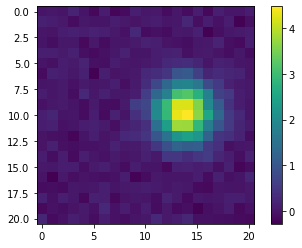

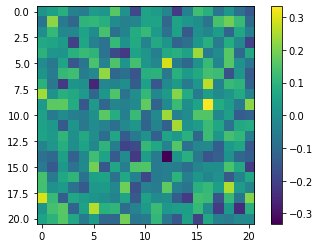

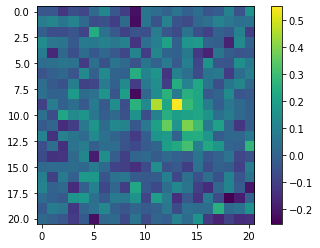

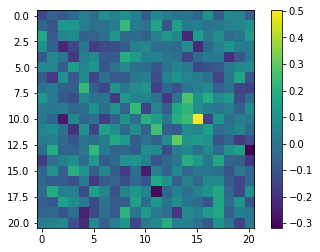

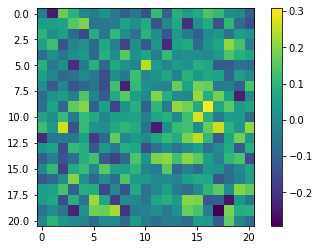

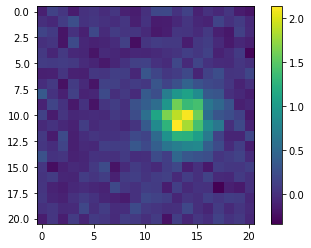

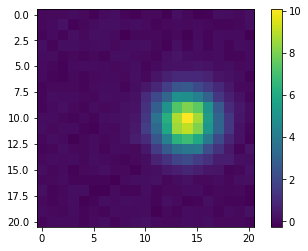

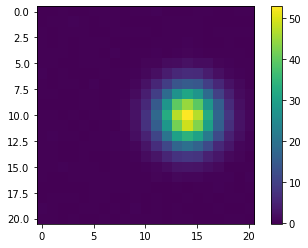

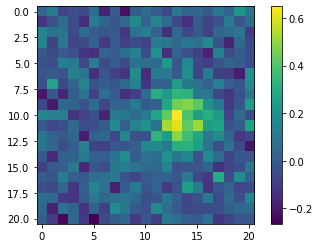

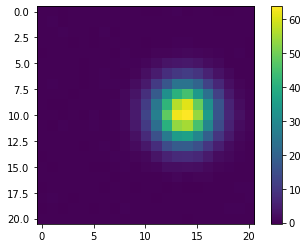

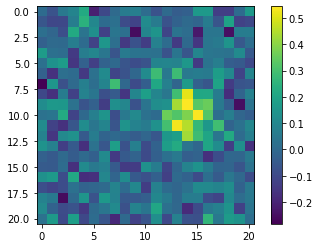

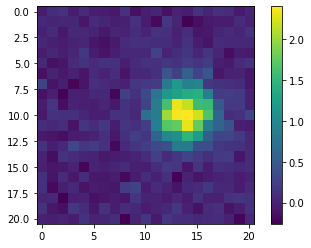

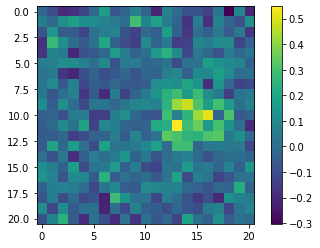

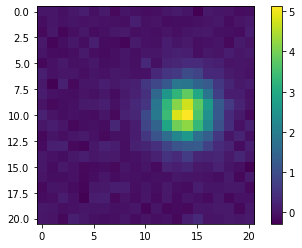

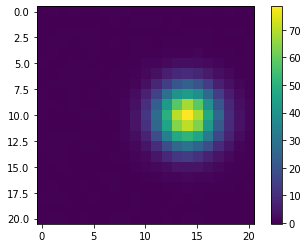

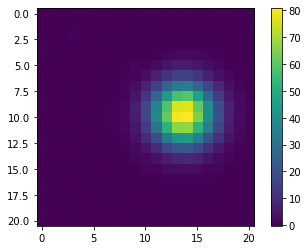

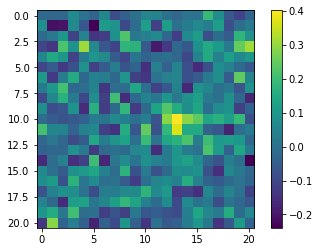

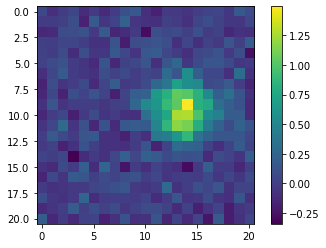

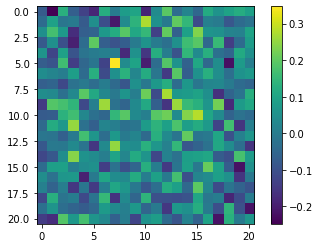

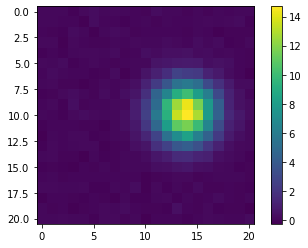

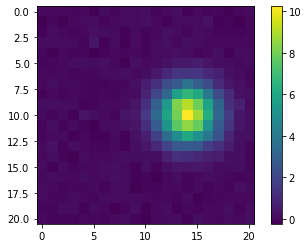

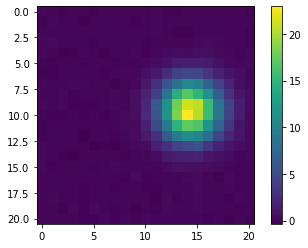

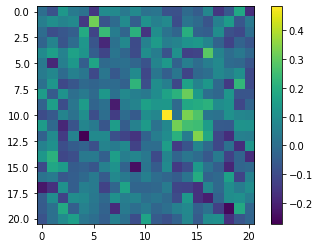

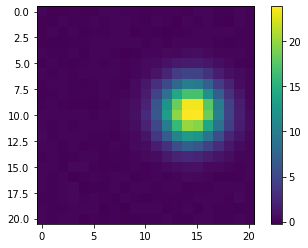

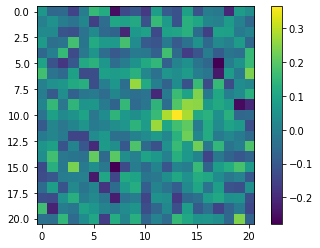

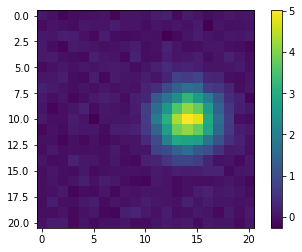

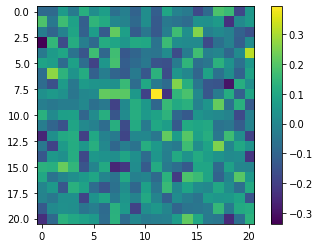

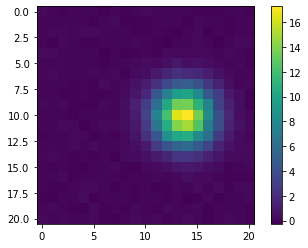

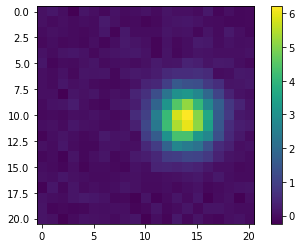

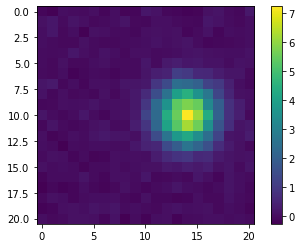

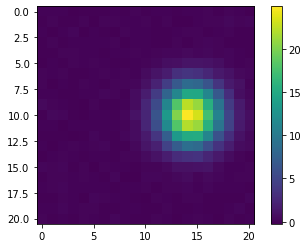

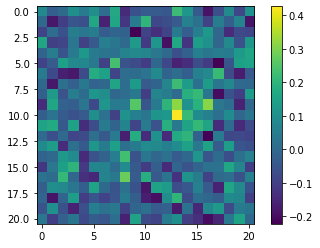

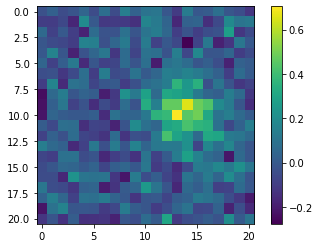

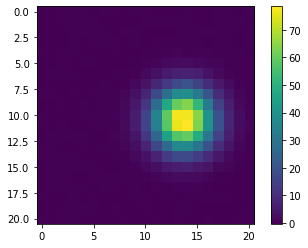

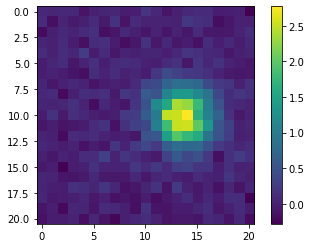

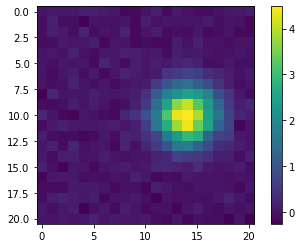

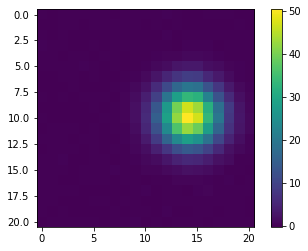

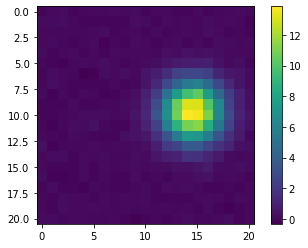

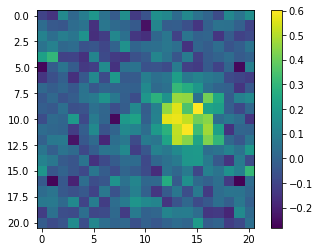

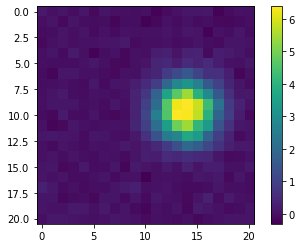

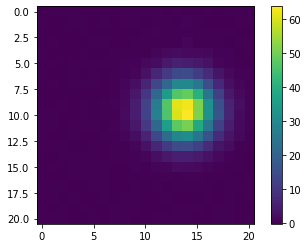

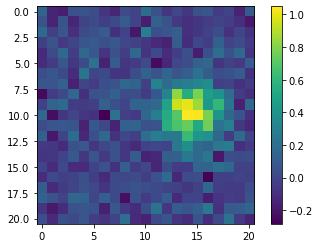

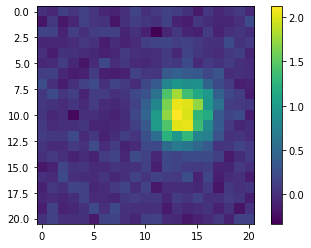

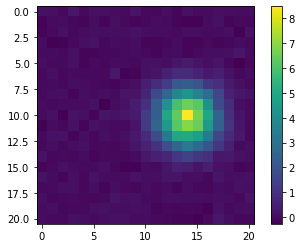

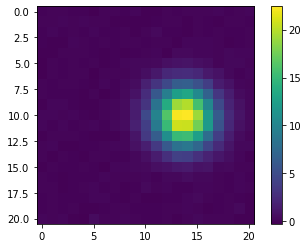

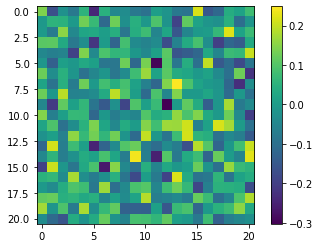

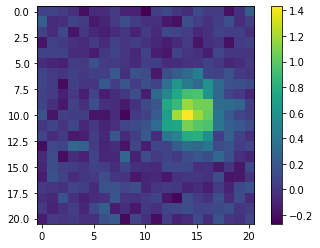

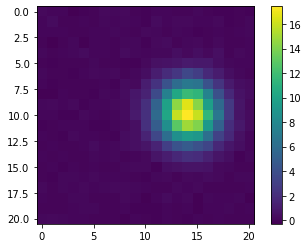

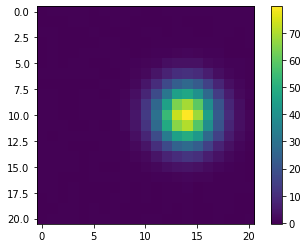

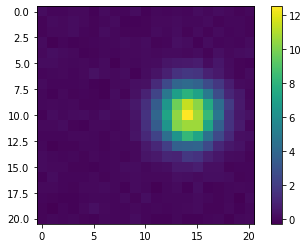

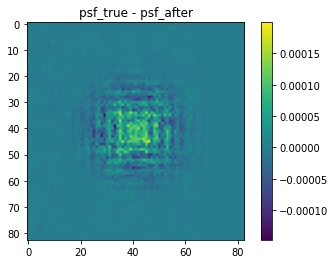

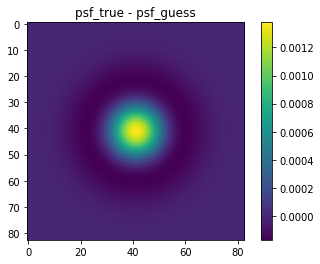

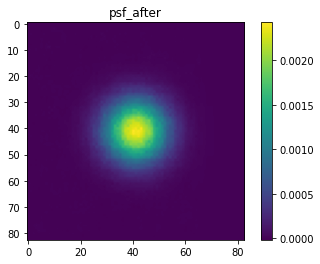

===== no error map ====


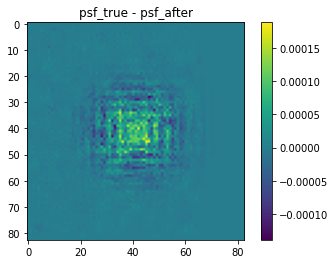

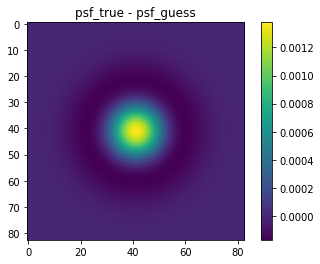

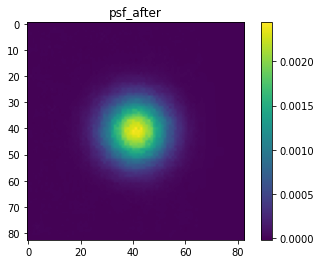

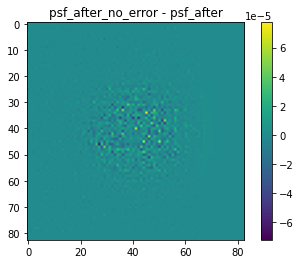

In [ ]:
from psfr.util import oversampled2regular
from lenstronomy.Util import kernel_util

def test_stack_psf(oversampling, num_stars, kwargs_one_step):
    
    from lenstronomy.LightModel.light_model import LightModel
    numpix = 21
    oversampling_compute = 5
    sigma_bkg = 0.1
    exp_time = 100
    

    numpix_super = numpix * oversampling * oversampling_compute
    if numpix_super % 2 == 0:
        numpix_super -= 1
        
    numpix_grid = numpix * oversampling_compute
    if numpix_grid % 2 == 0:
        numpix_grid -= 1

    x_grid, y_grid = util.make_grid(numPix=numpix_grid, deltapix=1. / oversampling_compute, left_lower=False)
    x_grid_super, y_grid_super = util.make_grid(numPix=numpix_super, deltapix=1. / oversampling / oversampling_compute, left_lower=False)
    gauss = LightModel(['GAUSSIAN'])
    sigma = 2
    kwargs_true = [{'amp': 1, 'sigma': sigma, 'center_x': 0, 'center_y': 0}]
    flux_true = gauss.surface_brightness(x_grid_super, y_grid_super, kwargs_true)
    psf_true = util.array2image(flux_true)
    psf_true = oversampled2regular(psf_true, oversampling=oversampling_compute)
    psf_true /= np.sum(psf_true)
    
    kwargs_guess = [{'amp': 1, 'sigma': sigma * 1.5, 'center_x': 0, 'center_y': 0}]
    flux_guess = gauss.surface_brightness(x_grid_super, y_grid_super, kwargs_guess)
    psf_guess = util.array2image(flux_guess)
    psf_guess = oversampled2regular(psf_guess, oversampling=oversampling_compute)
    psf_guess /= np.sum(psf_guess)
    
    center_list = []
    star_list = []
    error_map_list = []
    scatter_scale = 1
    for i in range(num_stars):
        x_c, y_c = np.random.uniform(-0.5, 0.5)*scatter_scale, np.random.uniform(-0.5, 0.5)*scatter_scale
        x_c += 4
        center_list.append(np.array([x_c, y_c]))
        log_amp = np.random.uniform(-1, 2)
        amp = 10 ** log_amp
        kwargs_model = [{'amp': amp, 'sigma': sigma, 'center_x': x_c, 'center_y': y_c}]
        flux_model = gauss.surface_brightness(x_grid, y_grid, kwargs_model)
        star = util.array2image(flux_model)
        star = oversampled2regular(star, oversampling=oversampling_compute)
        # add noise
        sigma_poisson = np.sqrt(np.abs(star)/exp_time)
        nx, ny = np.shape(star)
        noise = np.random.randn(nx, ny) * sigma_poisson + np.random.randn(nx, ny) * sigma_bkg
        star += noise
        star_list.append(star)
        error_map_list.append(sigma_poisson**2 + sigma_bkg**2)
        
        # plot star list
        plt.imshow(star)
        plt.colorbar()
        plt.show()
    
    n_center = 100
    num_iteration = 50
    psf_after, center_list_after, mask_list = stack_psf(star_list, oversampling=oversampling, 
                                                        saturation_limit=None, num_iteration=num_iteration, 
                                                        n_recenter=n_center, verbose=False, kwargs_one_step=kwargs_one_step, 
                                                        error_map_list=error_map_list)
    
    psf_true = kernel_util.cut_psf(psf_true, len(psf_after))
    psf_guess = kernel_util.cut_psf(psf_guess, len(psf_after))

    plt.imshow(psf_true - psf_after)
    plt.title('psf_true - psf_after')
    plt.colorbar()
    plt.show()
    plt.imshow(psf_true - psf_guess)
    plt.title('psf_true - psf_guess')
    plt.colorbar()
    plt.show()
    
    plt.imshow(psf_after )
    plt.title('psf_after')
    plt.colorbar()
    plt.show()
    
    print('===== no error map ====')
    
    
    psf_after_no_error, center_list_after, mask_list = stack_psf(star_list, oversampling=oversampling, 
                                                        saturation_limit=None, num_iteration=num_iteration, 
                                                        n_recenter=n_center, verbose=False, kwargs_one_step=kwargs_one_step, 
                                                        error_map_list=None)
    
    psf_true = kernel_util.cut_psf(psf_true, len(psf_after))
    psf_guess = kernel_util.cut_psf(psf_guess, len(psf_after))

    plt.imshow(psf_true - psf_after_no_error)
    plt.title('psf_true - psf_after')
    plt.colorbar()
    plt.show()
    plt.imshow(psf_true - psf_guess)
    plt.title('psf_true - psf_guess')
    plt.colorbar()
    plt.show()
    
    plt.imshow(psf_after_no_error )
    plt.title('psf_after')
    plt.colorbar()
    plt.show()
    
    plt.imshow(psf_after_no_error - psf_after)
    plt.title('psf_after_no_error - psf_after')
    plt.colorbar()
    plt.show()
    
    assert np.sum((psf_after - psf_true)**2) < np.sum((psf_guess - psf_true)**2)



kwargs_one_step= {'verbose': False, 
                 'oversampled_residual_deshifting': True,
                 'step_factor': 0.5,
                 'deshift_order': 1}
kwargs_one_step = {}
oversampling = 4
num_stars = 50

test_stack_psf(oversampling, num_stars, kwargs_one_step)

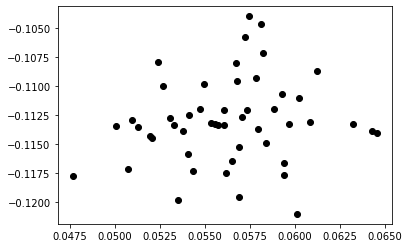

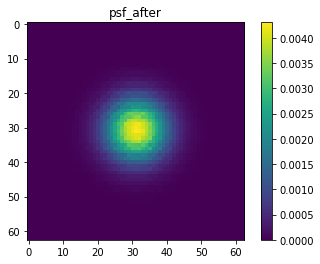

In [ ]:
# test astrometric precision

# initiate with very high resolution

# initial guesses slightly offset




def test_stack_psf(oversampling, num_stars, kwargs_one_step, with_error_map=True):
    
    from lenstronomy.LightModel.light_model import LightModel
    np.random.seed(41)
    numpix = 21
    oversampling_compute = 5
    sigma_bkg = 0.1
    exp_time = 100
    

    numpix_super = numpix * oversampling * oversampling_compute
    if numpix_super % 2 == 0:
        numpix_super -= 1
        
    numpix_grid = numpix * oversampling_compute
    if numpix_grid % 2 == 0:
        numpix_grid -= 1

    x_grid, y_grid = util.make_grid(numPix=numpix_grid, deltapix=1. / oversampling_compute, left_lower=False)
    x_grid_super, y_grid_super = util.make_grid(numPix=numpix_super, deltapix=1. / oversampling / oversampling_compute, left_lower=False)
    gauss = LightModel(['GAUSSIAN'])
    sigma = 2
    kwargs_true = [{'amp': 1, 'sigma': sigma, 'center_x': 0, 'center_y': 0}]
    flux_true = gauss.surface_brightness(x_grid_super, y_grid_super, kwargs_true)
    psf_true = util.array2image(flux_true)
    psf_true = oversampled2regular(psf_true, oversampling=oversampling_compute)
    psf_true /= np.sum(psf_true)
    
    
    center_list = []
    star_list = []
    error_map_list = []
    scatter_scale = 1
    for i in range(num_stars):
        x_c, y_c = np.random.uniform(-0.5, 0.5)*scatter_scale, np.random.uniform(-0.5, 0.5)*scatter_scale
        center_list.append(np.array([x_c, y_c]))
        log_amp = np.random.uniform(2, 3)
        amp = 10 ** log_amp
        kwargs_model = [{'amp': amp, 'sigma': sigma, 'center_x': x_c, 'center_y': y_c}]
        flux_model = gauss.surface_brightness(x_grid, y_grid, kwargs_model)
        star = util.array2image(flux_model)
        star = oversampled2regular(star, oversampling=oversampling_compute)
        # add noise
        sigma_poisson = np.sqrt(np.abs(star)/exp_time)
        nx, ny = np.shape(star)
        noise = np.random.randn(nx, ny) * sigma_poisson + np.random.randn(nx, ny) * sigma_bkg
        star += noise
        star_list.append(star)
        error_map_list.append(sigma_poisson**2 + sigma_bkg**2)
        
    n_center = 4
    num_iteration = 100
    if not with_error_map:
        error_map_list = None
    psf_after, center_list_after, mask_list = stack_psf(star_list, oversampling=oversampling, 
                                                        saturation_limit=None, num_iteration=num_iteration, 
                                                        n_recenter=n_center, verbose=False, kwargs_one_step=kwargs_one_step, 
                                                        error_map_list=error_map_list)
    # test recover vs truth
    for i, center_truth in enumerate(center_list):
        center_estimate = center_list_after[i]
        plt.plot(center_truth[0] - center_estimate[0], center_truth[1] - center_estimate[1], 'ko')
    plt.show()
    
    plt.imshow(psf_after)
    plt.title('psf_after')
    plt.colorbar()
    plt.show()
    

kwargs_one_step= {'verbose': False, 
                 'oversampled_residual_deshifting': True,
                 'step_factor': 0.5,
                 'deshift_order': 1}
kwargs_one_step = {}
oversampling = 3
num_stars = 50

test_stack_psf(oversampling, num_stars, kwargs_one_step, with_error_map=True)
    